In [ ]:
# !pip install seaborn

In [ ]:
# !pip install wordcloud

In [ ]:
# !pip install nltk

In [ ]:
# !pip install contractions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import contractions
from wordcloud import WordCloud

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, RocCurveDisplay, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\intag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\intag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('./real_fake_jobs_dataset/real_fake_job_postings.csv')

### Exploratory Data Analysis Part-1

In [3]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [4]:
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [5]:
df.shape

(17880, 18)

In [6]:
# missing values
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
# selecting features based on low amount of NaN values
df = df[['job_id', 'description', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']]
df.head()

,job_id,description,telecommuting,has_company_logo,has_questions,fraudulent
0,1,"Food52, a fast-growing, James Beard Award-winn...",0,1,0,0
1,2,Organised - Focused - Vibrant - Awesome!Do you...,0,1,0,0
2,3,"Our client, located in Houston, is actively se...",0,1,0,0
3,4,THE COMPANY: ESRI – Environmental Systems Rese...,0,1,0,0
4,5,JOB TITLE: Itemization Review ManagerLOCATION:...,0,1,1,0


In [8]:
# dropping rows if any entry is missing in selected feature
df.dropna(inplace=True)
df.shape

(17879, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17879 entries, 0 to 17879
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            17879 non-null  int64 
 1   description       17879 non-null  object
 2   telecommuting     17879 non-null  int64 
 3   has_company_logo  17879 non-null  int64 
 4   has_questions     17879 non-null  int64 
 5   fraudulent        17879 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 977.8+ KB


In [10]:
telecommuting_fraudulent = df[(df['fraudulent'] == 1) & (df['telecommuting'] == 1)]['job_id'].count()
non_telecommuting_fraudulent = df[(df['fraudulent'] == 1) & (df['telecommuting'] == 0)]['job_id'].count()

fraudulent_with_logo = df[(df['fraudulent'] == 1) & (df['has_company_logo'] == 1)]['job_id'].count()
fraudulent_without_logo = df[(df['fraudulent'] == 1) & (df['has_company_logo'] == 0)]['job_id'].count()

fraudulent_with_questions = df[(df['fraudulent'] == 1) & (df['has_questions'] == 1)]['job_id'].count()
fraudulent_without_questions = df[(df['fraudulent'] == 1) & (df['has_questions'] == 0)]['job_id'].count()

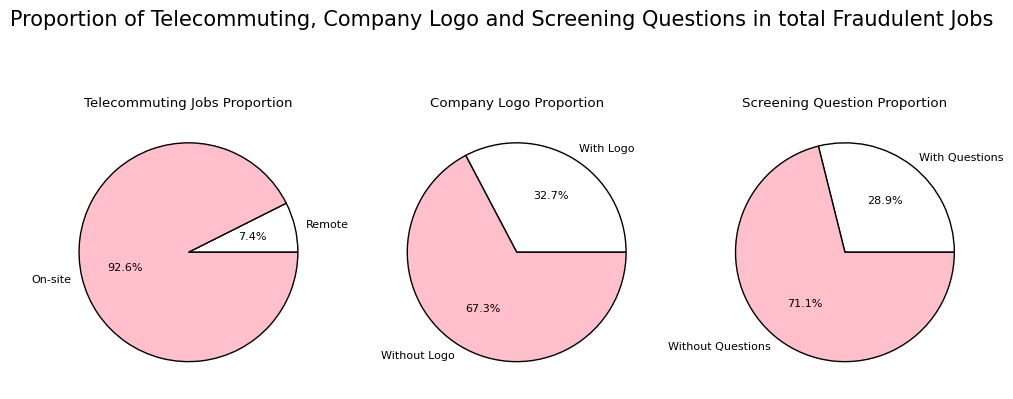

In [91]:
# creating three pie charts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

colors = ['white', 'pink']
labels = {1: ['Remote', 'On-site'], 2: ['With Logo', 'Without Logo'], 3: ['With Questions', 'Without Questions']}

# first pie chart
ax1.pie([telecommuting_fraudulent, non_telecommuting_fraudulent], labels=labels[1], autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, colors=colors)
ax1.set_title('Telecommuting Jobs Proportion')

# second pie chart
ax2.pie([fraudulent_with_logo, fraudulent_without_logo], labels=labels[2], autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, colors=colors)
ax2.set_title('Company Logo Proportion')

# third pie chart
ax3.pie([fraudulent_with_questions, fraudulent_without_questions], labels=labels[3], autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, colors=colors)
ax3.set_title('Screening Question Proportion')

# super title
fig.suptitle('Proportion of Telecommuting, Company Logo and Screening Questions in total Fraudulent Jobs', fontsize=15)

plt.savefig("fraudulent_job_variable_proportions.png", format='png')
plt.show()


In [13]:
# removing extra columns based on low contribution in fraudulent jobs
df.drop(columns=['telecommuting', 'has_company_logo', 'has_questions'], inplace=True)
df.columns

Index(['job_id', 'description', 'fraudulent'], dtype='object')

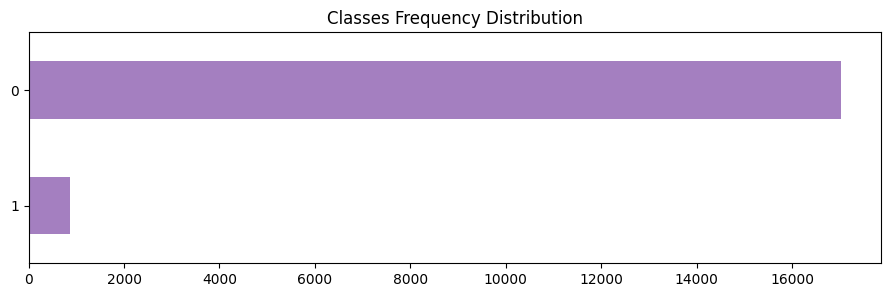

0    17014
1      865
Name: fraudulent, dtype: int64

In [20]:
# plotting entry frequency distribution for each class
plt.figure(figsize=(11,3))
plt.title('Classes Frequency Distribution')
df['fraudulent'].value_counts().sort_values().plot(kind = 'barh', color='indigo', alpha=0.5)

plt.savefig("Classes Frequency Distribution.png", format='png')
plt.show()

df.fraudulent.value_counts()

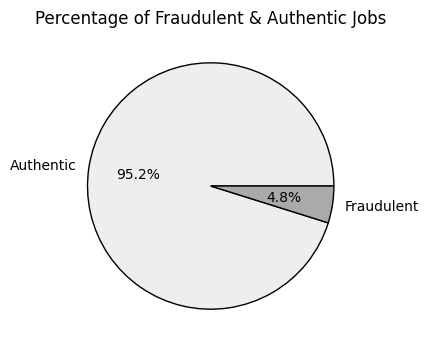

In [25]:
# creating pie chart
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

colors = ['#eee', '#aaa']
labels = ['Authentic', 'Fraudulent']

# pie chart
ax.pie(df.fraudulent.value_counts(), labels=labels, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, colors=colors)
plt.title('Percentage of Fraudulent & Authentic Jobs')

plt.savefig("Percentage of Fraudulent & Authentic Jobs.png", format='png')
plt.show()

In [26]:
df['description'][0]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

#### Data Cleaning

In [27]:
# removing alphanumeric characters
df['description'] = df['description'].str.replace('[^a-zA-Z\s]', ' ', regex=True)
df['description'][0]

'Food    a fast growing  James Beard Award winning online food community and crowd sourced and curated recipe hub  is currently interviewing full  and part time unpaid interns to work in a small team of editors  executives  and developers in its New York City headquarters Reproducing and or repackaging existing Food   content for a number of partner sites  such as Huffington Post  Yahoo  Buzzfeed  and more in their various content management systemsResearching blogs and websites for the Provisions by Food   Affiliate ProgramAssisting in day to day affiliate program support  such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR  amp  Events when neededHelping with office administrative work  such as filing  mailing  and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [28]:
# fixing contractions in job descriptions such as "don't -> does not"
df['description'] = df['description'].apply(lambda text: [contractions.fix(chunk) for chunk in text.split()]) # returns list of chunks for each row
# joining list of string chunks int to a single text string against each row
df['description'] = [' '.join(map(str, word)) for word in df['description']]
df['description'][0]

'Food a fast growing James Beard Award winning online food community and crowd sourced and curated recipe hub is currently interviewing full and part time unpaid interns to work in a small team of editors executives and developers in its New York City headquarters Reproducing and or repackaging existing Food content for a number of partner sites such as Huffington Post Yahoo Buzzfeed and more in their various content management systemsResearching blogs and websites for the Provisions by Food Affiliate ProgramAssisting in day to day affiliate program support such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR amp Events when neededHelping with office administrative work such as filing mailing and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [29]:
# tokenizing job descriptions
df['description'] = df['description'].apply(word_tokenize) # returns a list of tokens/words
print(df['description'][0])

['Food', 'a', 'fast', 'growing', 'James', 'Beard', 'Award', 'winning', 'online', 'food', 'community', 'and', 'crowd', 'sourced', 'and', 'curated', 'recipe', 'hub', 'is', 'currently', 'interviewing', 'full', 'and', 'part', 'time', 'unpaid', 'interns', 'to', 'work', 'in', 'a', 'small', 'team', 'of', 'editors', 'executives', 'and', 'developers', 'in', 'its', 'New', 'York', 'City', 'headquarters', 'Reproducing', 'and', 'or', 'repackaging', 'existing', 'Food', 'content', 'for', 'a', 'number', 'of', 'partner', 'sites', 'such', 'as', 'Huffington', 'Post', 'Yahoo', 'Buzzfeed', 'and', 'more', 'in', 'their', 'various', 'content', 'management', 'systemsResearching', 'blogs', 'and', 'websites', 'for', 'the', 'Provisions', 'by', 'Food', 'Affiliate', 'ProgramAssisting', 'in', 'day', 'to', 'day', 'affiliate', 'program', 'support', 'such', 'as', 'screening', 'affiliates', 'and', 'assisting', 'in', 'any', 'affiliate', 'inquiriesSupporting', 'with', 'PR', 'amp', 'Events', 'when', 'neededHelping', 'with'

In [30]:
# converting all characters to lowercase
df['description'] = df['description'].apply(lambda tokenized_list: [word.lower() for word in tokenized_list]) # return a list of lowercase words
print(df['description'][0])

['food', 'a', 'fast', 'growing', 'james', 'beard', 'award', 'winning', 'online', 'food', 'community', 'and', 'crowd', 'sourced', 'and', 'curated', 'recipe', 'hub', 'is', 'currently', 'interviewing', 'full', 'and', 'part', 'time', 'unpaid', 'interns', 'to', 'work', 'in', 'a', 'small', 'team', 'of', 'editors', 'executives', 'and', 'developers', 'in', 'its', 'new', 'york', 'city', 'headquarters', 'reproducing', 'and', 'or', 'repackaging', 'existing', 'food', 'content', 'for', 'a', 'number', 'of', 'partner', 'sites', 'such', 'as', 'huffington', 'post', 'yahoo', 'buzzfeed', 'and', 'more', 'in', 'their', 'various', 'content', 'management', 'systemsresearching', 'blogs', 'and', 'websites', 'for', 'the', 'provisions', 'by', 'food', 'affiliate', 'programassisting', 'in', 'day', 'to', 'day', 'affiliate', 'program', 'support', 'such', 'as', 'screening', 'affiliates', 'and', 'assisting', 'in', 'any', 'affiliate', 'inquiriessupporting', 'with', 'pr', 'amp', 'events', 'when', 'neededhelping', 'with'

In [31]:
# removing punctuation marks
punctuation_marks = string.punctuation
df['description'] = df['description'].apply(lambda smallcase_words: [word for word in smallcase_words if word not in punctuation_marks])
print(df['description'][0])

['food', 'a', 'fast', 'growing', 'james', 'beard', 'award', 'winning', 'online', 'food', 'community', 'and', 'crowd', 'sourced', 'and', 'curated', 'recipe', 'hub', 'is', 'currently', 'interviewing', 'full', 'and', 'part', 'time', 'unpaid', 'interns', 'to', 'work', 'in', 'a', 'small', 'team', 'of', 'editors', 'executives', 'and', 'developers', 'in', 'its', 'new', 'york', 'city', 'headquarters', 'reproducing', 'and', 'or', 'repackaging', 'existing', 'food', 'content', 'for', 'a', 'number', 'of', 'partner', 'sites', 'such', 'as', 'huffington', 'post', 'yahoo', 'buzzfeed', 'and', 'more', 'in', 'their', 'various', 'content', 'management', 'systemsresearching', 'blogs', 'and', 'websites', 'for', 'the', 'provisions', 'by', 'food', 'affiliate', 'programassisting', 'in', 'day', 'to', 'day', 'affiliate', 'program', 'support', 'such', 'as', 'screening', 'affiliates', 'and', 'assisting', 'in', 'any', 'affiliate', 'inquiriessupporting', 'with', 'pr', 'amp', 'events', 'when', 'neededhelping', 'with'

In [32]:
# removing stop words 
stop_words = set(stopwords.words('english'))
df['description'] = df['description'].apply(lambda no_punc_words: [word for word in no_punc_words if word not in stop_words])
print(df['description'][0])

['food', 'fast', 'growing', 'james', 'beard', 'award', 'winning', 'online', 'food', 'community', 'crowd', 'sourced', 'curated', 'recipe', 'hub', 'currently', 'interviewing', 'full', 'part', 'time', 'unpaid', 'interns', 'work', 'small', 'team', 'editors', 'executives', 'developers', 'new', 'york', 'city', 'headquarters', 'reproducing', 'repackaging', 'existing', 'food', 'content', 'number', 'partner', 'sites', 'huffington', 'post', 'yahoo', 'buzzfeed', 'various', 'content', 'management', 'systemsresearching', 'blogs', 'websites', 'provisions', 'food', 'affiliate', 'programassisting', 'day', 'day', 'affiliate', 'program', 'support', 'screening', 'affiliates', 'assisting', 'affiliate', 'inquiriessupporting', 'pr', 'amp', 'events', 'neededhelping', 'office', 'administrative', 'work', 'filing', 'mailing', 'preparing', 'meetingsworking', 'developers', 'document', 'bugs', 'suggest', 'improvements', 'sitesupporting', 'marketing', 'executive', 'staff']


In [33]:
# lemmatizing different forms of words
lemmatizer = WordNetLemmatizer()
df['lemmatized_description'] = df['description'].apply(lambda clean_words: [lemmatizer.lemmatize(word, 'v') for word in clean_words if len(word) > 2]) # return a list of lemmatized words
print(df['lemmatized_description'][0])

['food', 'fast', 'grow', 'jam', 'beard', 'award', 'win', 'online', 'food', 'community', 'crowd', 'source', 'curated', 'recipe', 'hub', 'currently', 'interview', 'full', 'part', 'time', 'unpaid', 'intern', 'work', 'small', 'team', 'editors', 'executives', 'developers', 'new', 'york', 'city', 'headquarter', 'reproduce', 'repackaging', 'exist', 'food', 'content', 'number', 'partner', 'sit', 'huffington', 'post', 'yahoo', 'buzzfeed', 'various', 'content', 'management', 'systemsresearching', 'blog', 'websites', 'provision', 'food', 'affiliate', 'programassisting', 'day', 'day', 'affiliate', 'program', 'support', 'screen', 'affiliate', 'assist', 'affiliate', 'inquiriessupporting', 'amp', 'events', 'neededhelping', 'office', 'administrative', 'work', 'file', 'mail', 'prepare', 'meetingsworking', 'developers', 'document', 'bug', 'suggest', 'improvements', 'sitesupporting', 'market', 'executive', 'staff']


### Exploratory Data Analysis Part-2

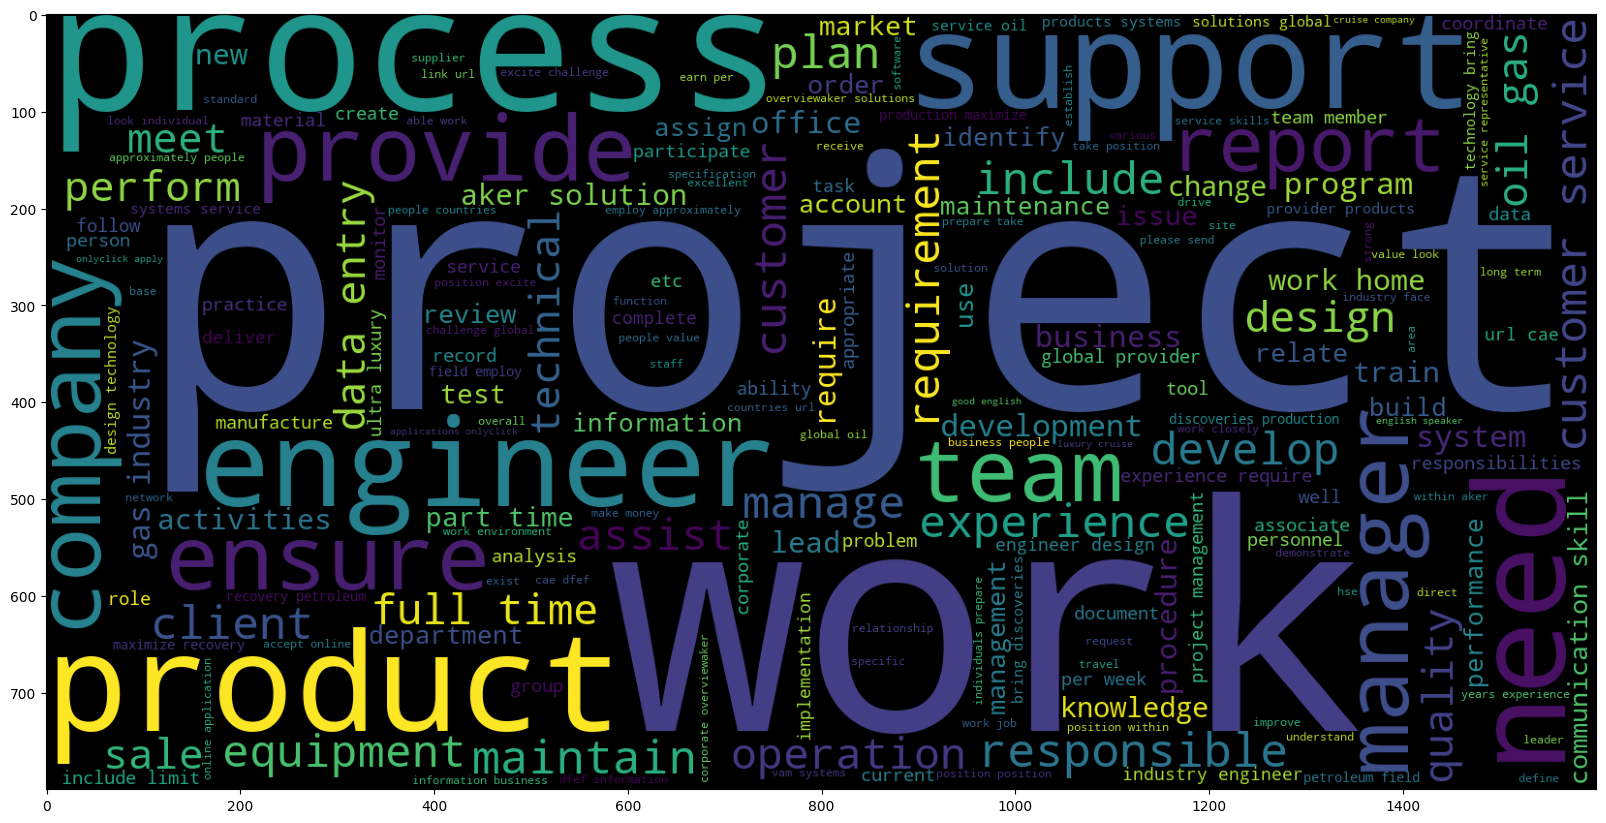

In [34]:
# plotting Word Cloud for Fraudulent Jobs
plt.figure(figsize = (20,20))
text = ' '.join(df[df['fraudulent']==1].lemmatized_description.explode().astype(str))
word_cloud = WordCloud(max_words = 200, width=1600, height=800).generate(text)
plt.savefig("Word Cloud for Fraudulent Jobs.png", format='png')
plt.imshow(word_cloud)

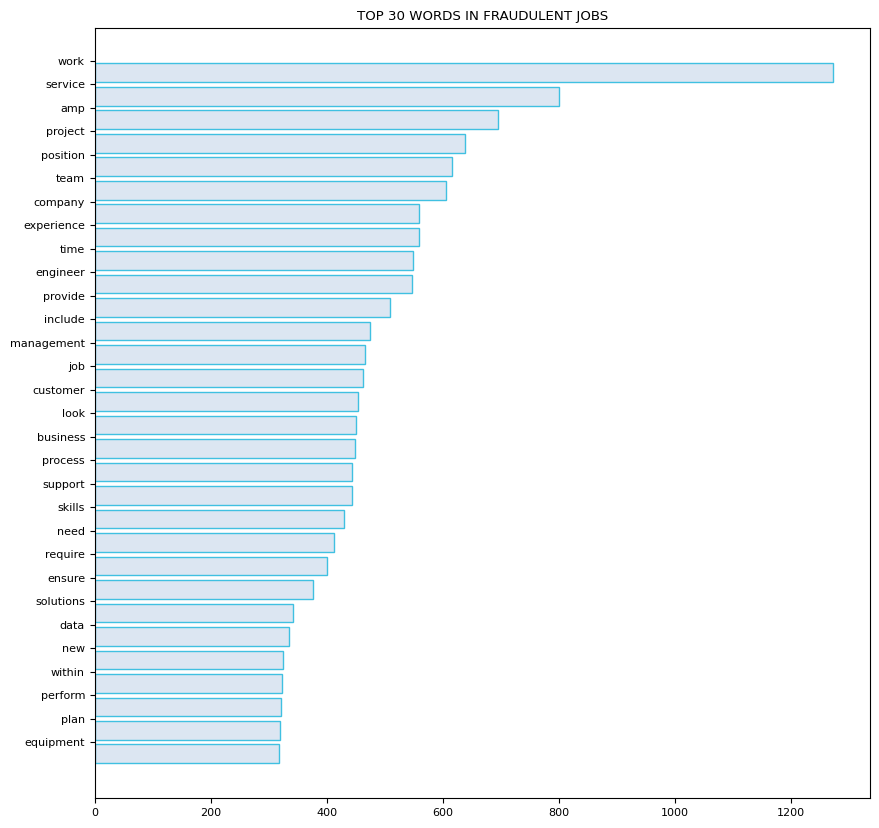

In [35]:
# plotting word's Frequency Distribution plot for Fraudulent Jobs
all_text_words = text.split()
term_frequency = FreqDist(all_text_words)
term_frequency_dict = dict(term_frequency)
sorted_term_freq_dict = sorted(term_frequency_dict, key = term_frequency_dict.get, reverse = True)

word_count = 30
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size':8})
plt.barh(range(word_count), [term_frequency_dict[w] for w in reversed(sorted_term_freq_dict[0:word_count])], color='#dce6f2', edgecolor='#40c0e1')
plt.yticks([x + 0.5 for x in range(word_count)], reversed(sorted_term_freq_dict[0:word_count]))
plt.title('TOP 30 WORDS IN FRAUDULENT JOBS')

plt.savefig("TOP 30 WORDS IN FRAUDULENT JOBS.png", format='png')
plt.show()

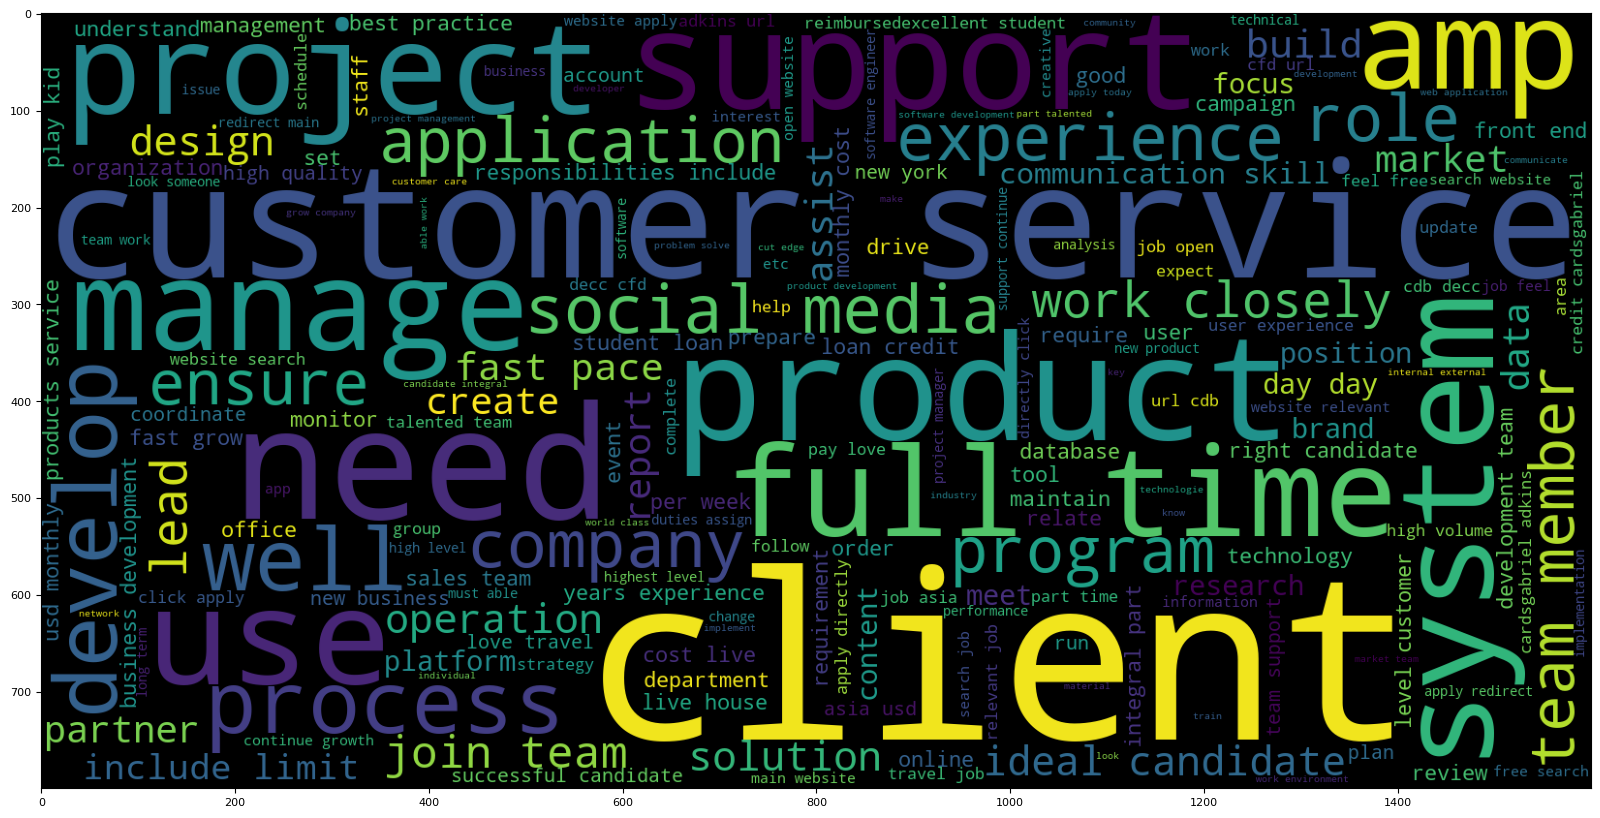

In [36]:
# plotting Word Cloud for Authentic Jobs
plt.figure(figsize = (20,20))
text = ' '.join(df[df['fraudulent']==0].lemmatized_description.explode().astype(str))
word_cloud = WordCloud(max_words = 200, width=1600, height=800).generate(text)

plt.savefig("Word Cloud for Authentic Jobs.png", format='png')
plt.imshow(word_cloud)

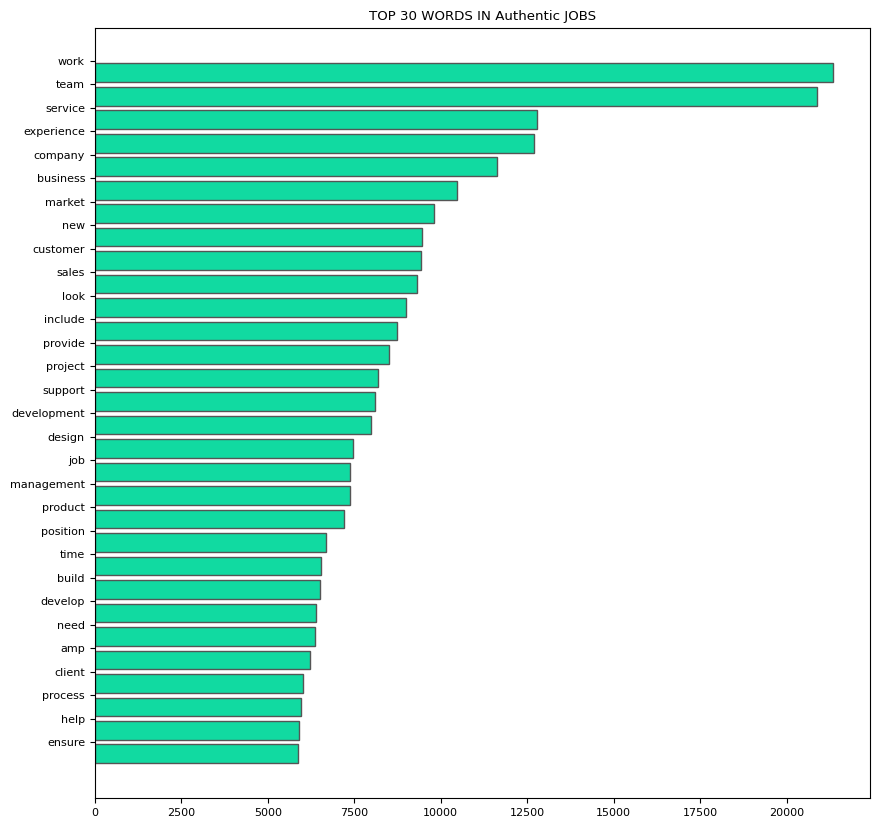

In [58]:
# plotting word's Frequency Distribution plot for Authentic Jobs
all_text_words = text.split()
term_frequency = FreqDist(all_text_words)
term_frequency_dict = dict(term_frequency)
sorted_term_freq_dict = sorted(term_frequency_dict, key = term_frequency_dict.get, reverse = True)

word_count = 30
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size':8})
plt.barh(range(word_count), [term_frequency_dict[w] for w in reversed(sorted_term_freq_dict[0:word_count])], color='#11daa1', edgecolor='#555')
plt.yticks([x + 0.5 for x in range(word_count)], reversed(sorted_term_freq_dict[0:word_count]))
plt.title('TOP 30 WORDS IN Authentic JOBS')

plt.savefig("TOP 30 WORDS IN Authentic JOBS.png", format='png')
plt.show()

In [59]:
# vectorizing text descriptions using Term Frequency Distribution Vectorizer
vectorizer = TfidfVectorizer()
df['text_description'] = [' '.join(map(str, word)) for word in df['lemmatized_description']]
term_freq_vectorizer = vectorizer.fit_transform(df['text_description'])
print('Total Features: ', len(vectorizer.get_feature_names_out()))

Total Features:  53038


In [60]:
X = term_freq_vectorizer
X.shape

(17879, 53038)

In [61]:
y = df['fraudulent']
y.shape

(17879,)

## Modeling with 70/30 Split Dataset

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Naive Bayes Classifier

In [63]:
# building Multinomial Naive Bayes Classifier
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)
y_predict_train = NB_classifier.predict(X_train)
y_predict_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### NBC Training Performance

In [64]:
accuracy = NB_classifier.score(X_train, y_train)
print('Accuracy: ', accuracy)

Accuracy:  0.9478226128645625


In [65]:
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11875
           1       0.00      0.00      0.00       640

    accuracy                           0.95     12515
   macro avg       0.47      0.50      0.49     12515
weighted avg       0.90      0.95      0.92     12515



<Figure size 640x480 with 0 Axes>

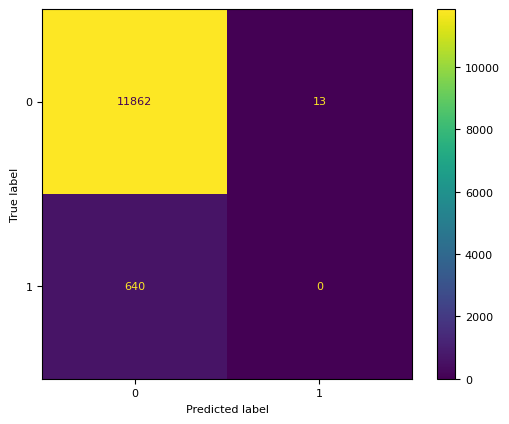

In [66]:
# Displaying Confusion Matrix for training data
cm = confusion_matrix(y_train, y_predict_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=NB_classifier.classes_)

plt.savefig("Naive Bayes Confusion Matrix for training data.png", format='png')
disp.plot()

#### NBC Testing Performance

In [67]:
accuracy = NB_classifier.score(X_test, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9569351230425056


In [68]:
y_predict_test = NB_classifier.predict(X_test)
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5139
           1       0.12      0.00      0.01       225

    accuracy                           0.96      5364
   macro avg       0.54      0.50      0.49      5364
weighted avg       0.92      0.96      0.94      5364



<Figure size 640x480 with 0 Axes>

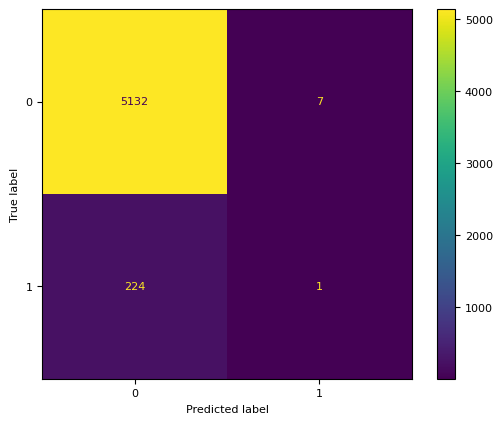

In [69]:
# Displaying Confusion Matrix for test data
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=NB_classifier.classes_)

plt.savefig("Naive Bayes Confusion Matrix for test data.png", format='png')
disp.plot()

In [70]:
# calculating specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test).ravel()
specificity = tn / (tn + fp)
print('Specificity: ', specificity)

Specificity:  0.9986378672893559


In [71]:
# calculating sensitivity
sensitivity = tp / (tp + fn)
print('Sensitivity: ', sensitivity)

Sensitivity:  0.0044444444444444444


#### ROC Curve

C:\Users\intag\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


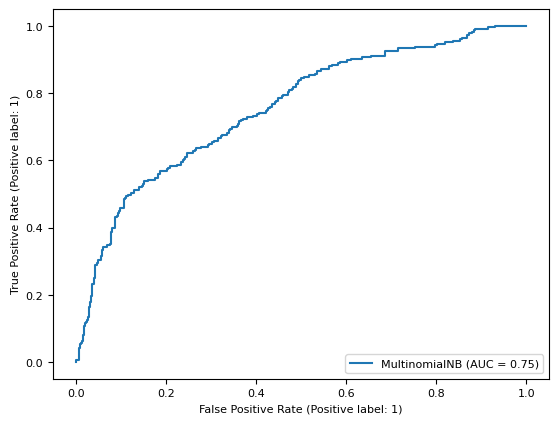

In [72]:
# plotting ROC Curve
plot_roc_curve(NB_classifier, X_test, y_test)
plt.savefig("Naive Bayes ROC Curve for test data.png", format='png')

### Decision Tree Classifier

In [73]:
# building Decision Tree Classifier
DT_classifier = DecisionTreeClassifier(random_state=42)
DT_classifier.fit(X_train, y_train)
y_predict_test = DT_classifier.predict(X_test)

#### DTC Testing Performance

In [74]:
accuracy = DT_classifier.score(X_test, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9718493661446681


In [75]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5139
           1       0.65      0.70      0.68       225

    accuracy                           0.97      5364
   macro avg       0.82      0.84      0.83      5364
weighted avg       0.97      0.97      0.97      5364



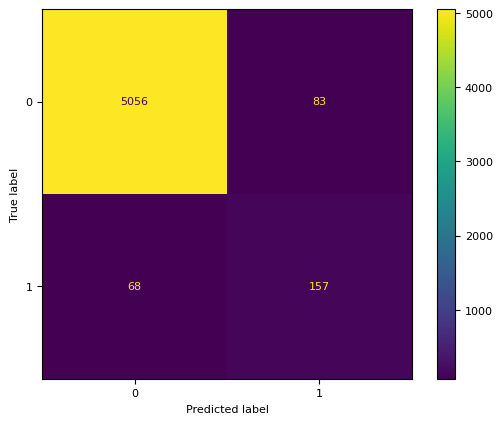

In [76]:
# Displaying Confusion Matrix for test data
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT_classifier.classes_)
disp.plot()

In [77]:
# calculating specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test).ravel()
specificity = tn / (tn + fp)
specificity

0.9838489978595057

In [78]:
# calculating sensitivity
sensitivity = tp / (tp + fn)
sensitivity

0.6977777777777778

#### ROC Curve

C:\Users\intag\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


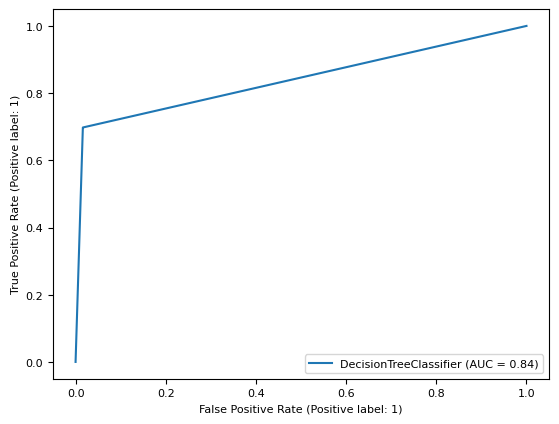

In [79]:
# plotting ROC Curve
plot_roc_curve(DT_classifier, X_test, y_test)
plt.savefig("Decision Tree ROC Curve for test data.png", format='png')

### K-Neighbors Classifier

In [80]:
# building K-Neighbors Classifier
KN_classifier = KNeighborsClassifier(n_neighbors=3)
KN_classifier.fit(X_train, y_train)
y_predict_test = KN_classifier.predict(X_test)

#### KNC Testing Performance

In [81]:
accuracy = accuracy = KN_classifier.score(X_test, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9614093959731543


In [82]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5139
           1       0.53      0.79      0.63       225

    accuracy                           0.96      5364
   macro avg       0.76      0.88      0.81      5364
weighted avg       0.97      0.96      0.97      5364



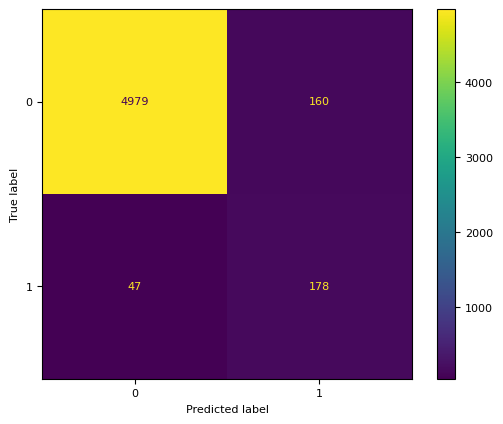

In [83]:
# Displaying Confusion Matrix for test data
cm = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KN_classifier.classes_)
disp.plot()

In [84]:
# calculating specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test).ravel()
specificity = tn / (tn + fp)
specificity

0.9688655380424207

In [85]:
# calculating sensitivity
sensitivity = tp / (tp + fn)
sensitivity

0.7911111111111111

#### ROC Curve

C:\Users\intag\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


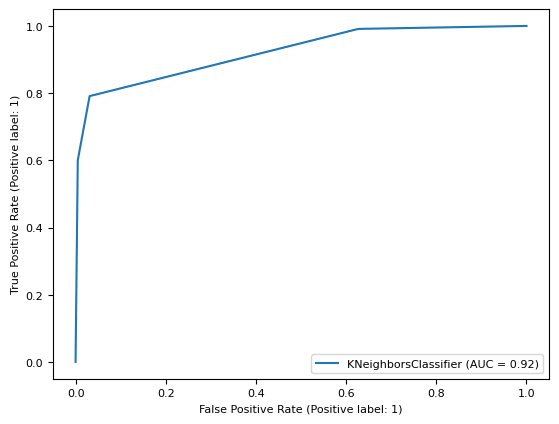

In [86]:
# plotting ROC Curve
plot_roc_curve(KN_classifier, X_test, y_test)
plt.savefig("K-Neighbors ROC Curve for test data.png", format='png')

## Modeling with K-Fold Cross Validation

In [87]:
X = term_freq_vectorizer
y = df['fraudulent'].to_numpy()

random_state = 42

# creating classifiers
NB_classifier = MultinomialNB()
DT_classifier = DecisionTreeClassifier(random_state=random_state)
KN_classifier = KNeighborsClassifier(n_neighbors=10)

classifiers = [NB_classifier, DT_classifier, KN_classifier]
classifier_names = ["Naive Bayes", "Decision Tree", "K-Neighbors"]

k = 10
k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

# initializing arrays for classifiers evaluation
accuracy_scores = np.zeros((k, len(classifiers)))
precision_scores = np.zeros((k, len(classifiers)))
recall_scores = np.zeros((k, len(classifiers)))
f1_scores = np.zeros((k, len(classifiers)))

fprs = [] # False Positive Rate
tprs = [] # True Positive Rate
aucs = [] # Area Under Curve
mean_fpr = np.linspace(0, 1, 100)

# K-fold cross validation
for kth_fold, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for ith_classifier, clf in enumerate(classifiers):
        clf.fit(X_train, y_train)
        y_predict_test = clf.predict(X_test)
        
        # calculating False Positive Rate (FPR) & True Positive Rate (TPR) for ROC curves and AUC
        fpr, tpr, _ = roc_curve(y_test, y_predict_test)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc(fpr, tpr))
        
        # calculating Accuracy, Precision, Recall and F1 Scores
        accuracy_scores[kth_fold, ith_classifier] = accuracy_score(y_test, y_predict_test)
        precision_scores[kth_fold, ith_classifier] = precision_score(y_test, y_predict_test)
        recall_scores[kth_fold, ith_classifier] = recall_score(y_test, y_predict_test)
        f1_scores[kth_fold, ith_classifier] = f1_score(y_test, y_predict_test)

#### ROC Curves

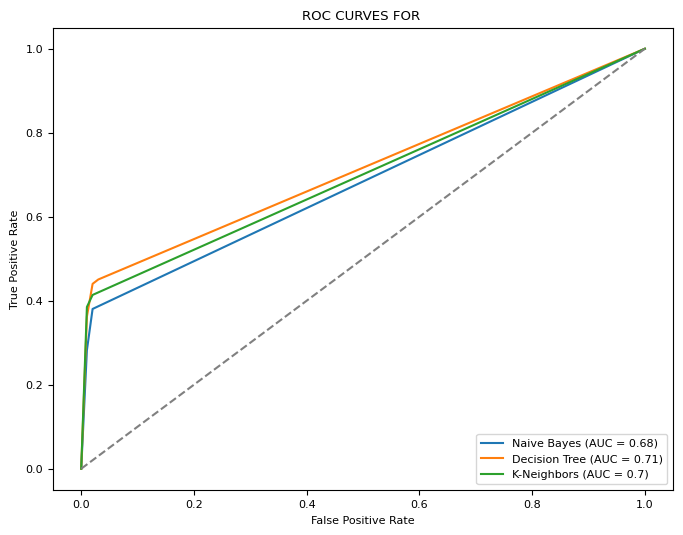

In [88]:
# plot ROC curves for each classifier
plt.figure(figsize=(8, 6))
for i in range(len(classifiers)):
    # selecting 10 tprs and aucs in sequence
    mean_tpr = np.mean(tprs[i*k:(i+1)*k], axis=0)
    mean_auc = np.mean(aucs[i*k:(i+1)*k]).round(2)
    plt.plot(mean_fpr, mean_tpr, label=f"{classifier_names[i]} (AUC = {mean_auc})")
    
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('ROC CURVES FOR ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig("K-Fold CV ROC curves.png", format='png')
plt.show()

#### Evaluation Matrics

In [89]:
# calculating means for each classifier accross K-Folds
accuracy_means = np.mean(accuracy_scores, axis=0)
precision_means = np.mean(precision_scores, axis=0)
recall_means = np.mean(recall_scores, axis=0)
f1_means = np.mean(f1_scores, axis=0)

performances = {
    'Classifier': classifier_names,
    'Mean_Accuracy': accuracy_means,
    'Mean_Precision': precision_means,
    'Mean_Recall': recall_means,
    'Mean_F1Score': f1_means,
}

performance_df = pd.DataFrame.from_dict(performances)
performance_df = performance_df.set_index('Classifier')
performance_df

,Mean_Accuracy,Mean_Precision,Mean_Recall,Mean_F1Score
Classifier,,,,
Naive Bayes,0.950053,0.050000,0.001149,0.002247
Decision Tree,0.970524,0.705831,0.682077,0.691442
K-Neighbors,0.969965,0.781081,0.529484,0.629450


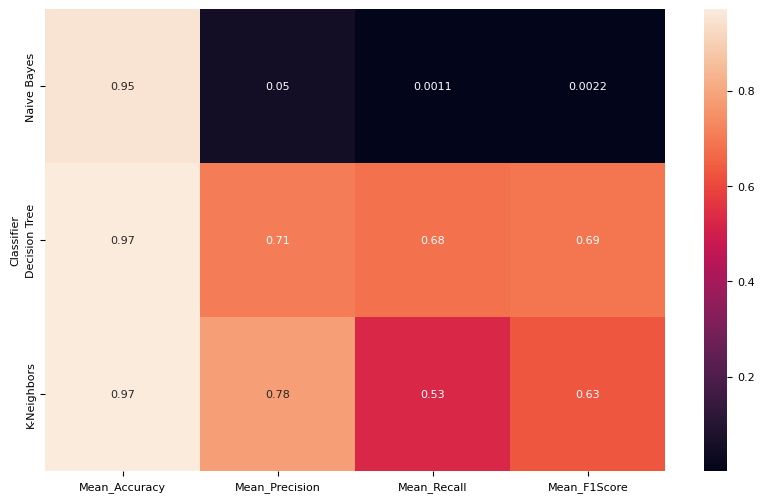

In [90]:
# plotting heatmap for performance matrics 
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True)
plt.savefig("heatmap for K-Fold performance matrics.png", format='png')